In [1]:
# 패키지 로드
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from collections import defaultdict
import os, random

from scipy import sparse
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch.nn.init import normal_
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

import plotnine
from plotnine import *

In [2]:
# 하이퍼파라미터 
class cfg: 
    gpu_idx = 0
    device = torch.device("cuda:{}".format(gpu_idx) if torch.cuda.is_available() else "cpu")
    top_k = 25 #############
    seed = 42
    neg_ratio = 100 #######
    test_size = 0.2

In [3]:
# 하이퍼 파라미터 설정 
cfg.batch_size = 256
cfg.emb_dim = 256
cfg.layer_dim1 = 512
# cfg.layer_dim2 = 512
cfg.dropout = 0.1
cfg.epochs = 50
cfg.learning_rate = 0.0025
cfg.reg_lambda = 0
cfg.check_epoch = 1

In [4]:
# 시드 고정 
def seed_everything(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)
    
seed_everything(cfg.seed)

In [5]:
# 경로 설정
data_path = './data'
saved_path = './code/saved'
output_path = './code/submission'

In [6]:
history_df = pd.read_csv(os.path.join(data_path, 'history_data.csv'), encoding='utf-8')
profile_df = pd.read_csv(os.path.join(data_path, 'profile_data.csv'), encoding='utf-8')
meta_df = pd.read_csv(os.path.join(data_path, 'meta_data.csv'), encoding='utf-8')
watch_e_df = pd.read_csv(os.path.join(data_path, 'watch_e_data.csv'), encoding='utf-8')
search_df =  pd.read_csv(os.path.join(data_path, 'search_data.csv'), encoding='utf-8')
buy_df = pd.read_csv(os.path.join(data_path, 'buy_data.csv'), encoding='utf-8')
meta_plus_df = pd.read_csv(os.path.join(data_path, 'meta_data_plus.csv'), encoding='utf-8')

## make 'watch' variable

In [7]:
### cumsum
# 어떤 데이터프레임에 새로운 칼럼 cumtime을 추가
# watch_time변수를 기준으로 사용자의 각 아이템에 대한 시청 시간 누적합을 나타냄
def cum_sum(group):
    group['cumtime'] = group.sort_values(
        by=['profile_id', 'album_id'], ascending=False).watch_time.cumsum()
    return group

In [8]:
# 시청 종료 데이터에서 실제 시청 길이인 'watch_time'과 콘텐츠 길이인'total_time' 칼럼 살림
we_d = watch_e_df[["profile_id", "album_id", "act_target_dtl", "watch_time", "total_time"]]

# 누적 시청 시간인 cumtime 변수를 cum_sum 함수를 적용하여 생성
#### 이게 생각보다 오래 걸림 (한 10분 걸리는듯?)-> 아래 피클 있길래 저장해둠 그거 쓰면 될 듯
we_d = we_d.groupby(["profile_id","album_id"]).apply(cum_sum)

In [9]:
# 동일 콘텐츠의 재생 횟수 의미하는 'watch' 칼럼 추가
we_d["watch"] = we_d["cumtime"]/we_d["total_time"]

In [10]:
watch = pd.DataFrame(we_d.groupby(['profile_id', 'album_id']).watch.max()).reset_index()

In [11]:
watch

,profile_id,album_id,watch
0,3,15,1.000000
1,3,16,0.990476
2,3,17,1.000000
3,3,18,0.985294
4,3,19,1.000000
...,...,...,...
347977,33032,7105,17.019231
347978,33032,8838,1.996700
347979,33032,8910,0.996678
347980,33032,15663,0.006351


In [12]:
watch_dict = dict()
for index, profile, album, watch in watch.itertuples():
    watch_dict[(profile, album)] = watch
    
print(watch_dict)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [38]:
import pickle

with open('watch.pickle', 'wb') as f:
    pickle.dump(watch_dict, f)

In [7]:
import pickle

with open('watch.pickle', 'rb') as f:
    watch_dict = pickle.load(f)

In [8]:
len(watch_dict)

347982

In [9]:
watch_dict

{(3, 15): 1.0,
 (3, 16): 0.9904761904761905,
 (3, 17): 1.0,
 (3, 18): 0.9852941176470589,
 (3, 19): 1.0,
 (3, 20): 2.0,
 (3, 21): 1.0756302521008403,
 (3, 22): 1.0,
 (3, 23): 0.9917355371900827,
 (3, 24): 1.0,
 (3, 25): 1.0,
 (3, 26): 1.0,
 (3, 27): 1.0,
 (3, 28): 0.9915966386554622,
 (3, 29): 1.0,
 (3, 30): 0.9917355371900827,
 (3, 31): 1.0,
 (3, 32): 1.0,
 (5, 0): 0.9926470588235294,
 (5, 15): 4.6521739130434785,
 (5, 16): 4.066666666666666,
 (5, 17): 3.0,
 (5, 18): 3.985294117647059,
 (5, 19): 3.0,
 (5, 38): 2.2378378378378376,
 (5, 39): 1.9945945945945946,
 (5, 40): 0.9945945945945946,
 (5, 41): 0.9944444444444445,
 (5, 42): 2.967741935483871,
 (5, 43): 0.9945945945945946,
 (5, 44): 1.0,
 (5, 45): 1.9891891891891893,
 (5, 46): 1.3297297297297297,
 (5, 50): 0.9928571428571429,
 (5, 51): 1.0,
 (5, 65): 0.5634328358208955,
 (5, 66): 0.043689320388349516,
 (5, 67): 1.1956521739130435,
 (5, 68): 0.3137254901960784,
 (5, 69): 1.0,
 (5, 70): 1.8992481203007519,
 (5, 71): 3.014084507042253

In [10]:
# 데이터 전처리 (중복제거) 
# 참고 : drop_duplicates의 subset을 무엇으로 구성하냐에 따라서 제거되는 항목들이 다름 
# ex) 'profile_id', 'album_id' : 중복된 시청이력 모두 제거 / 'profile_id', 'album_id', 'log_time' : 같은 시간에 시청한 이력만 제거 
data = history_df[['profile_id', 'log_time', 'album_id']].drop_duplicates(subset=['profile_id', 'album_id', 'log_time']).sort_values(by = ['profile_id', 'log_time']).reset_index(drop = True)
data['rating'] = 1

cfg.n_users = data.profile_id.max()+1
cfg.n_items = data.album_id.max()+1

In [11]:
# 학습 및 검증 데이터 분리
train, valid = train_test_split(
    data, test_size=cfg.test_size, random_state=cfg.seed,
)
print('학습 데이터 크기:', train.shape)
print('검증 데이터 크기:', valid.shape)

학습 데이터 크기: (719401, 4)
검증 데이터 크기: (179851, 4)


In [12]:
# Matrix 형태로 변환 
train = train.to_numpy()
matrix = sparse.lil_matrix((cfg.n_users, cfg.n_items))  
for (p, _, i, r) in tqdm(train):
    matrix[p, i] = r
    
train = sparse.csr_matrix(matrix)
train = train.toarray()
print("train 형태: \n", train)

100%|███████████████████████████████| 719401/719401 [00:01<00:00, 360439.55it/s]


train 형태: 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [13]:
profile_df = profile_df.set_index('profile_id')

le = LabelEncoder()
profile_df['sex'] = le.fit_transform(profile_df['sex'])
profile_df['pr_interest_keyword_cd_1'] = le.fit_transform(profile_df['pr_interest_keyword_cd_1'])
profile_df['pr_interest_keyword_cd_2'] = le.fit_transform(profile_df['pr_interest_keyword_cd_2'])
profile_df['pr_interest_keyword_cd_3'] = le.fit_transform(profile_df['pr_interest_keyword_cd_3'])
profile_df['ch_interest_keyword_cd_1'] = le.fit_transform(profile_df['ch_interest_keyword_cd_1'])
profile_df['ch_interest_keyword_cd_2'] = le.fit_transform(profile_df['ch_interest_keyword_cd_2'])
profile_df['ch_interest_keyword_cd_3'] = le.fit_transform(profile_df['ch_interest_keyword_cd_3'])

In [14]:
# 유저 특징 정보 추출 
user_features = profile_df[['age', 'sex',
                            'pr_interest_keyword_cd_1',
                            'pr_interest_keyword_cd_2',
                            'pr_interest_keyword_cd_3',
                            'ch_interest_keyword_cd_1',
                            'ch_interest_keyword_cd_2',
                            'ch_interest_keyword_cd_3']].to_dict()

In [15]:
cfg.n_pr_interest_keyword_1 = profile_df['pr_interest_keyword_cd_1'].nunique()
cfg.n_ch_interest_keyword_1 = profile_df['ch_interest_keyword_cd_1'].nunique()
cfg.n_pr_interest_keyword_2 = profile_df['pr_interest_keyword_cd_2'].nunique()
cfg.n_ch_interest_keyword_2 = profile_df['ch_interest_keyword_cd_2'].nunique()
cfg.n_pr_interest_keyword_3 = profile_df['pr_interest_keyword_cd_3'].nunique()
cfg.n_ch_interest_keyword_3 = profile_df['ch_interest_keyword_cd_3'].nunique()

In [16]:
meta_df = meta_df.set_index('album_id')

In [17]:
meta_df['genre_large'] = le.fit_transform(meta_df['genre_large'])
meta_df['genre_mid'] = le.fit_transform(meta_df['genre_mid'])
meta_df['genre_small'] = le.fit_transform(meta_df['genre_small'])
meta_df['cast_1'] = le.fit_transform(meta_df['cast_1'])
meta_df['cast_2'] = le.fit_transform(meta_df['cast_2'])
meta_df['cast_3'] = le.fit_transform(meta_df['cast_3'])
meta_df['cast_4'] = le.fit_transform(meta_df['cast_4'])
meta_df['cast_5'] = le.fit_transform(meta_df['cast_5'])
meta_df['cast_6'] = le.fit_transform(meta_df['cast_6'])
meta_df['cast_7'] = le.fit_transform(meta_df['cast_7'])

In [18]:
item_features = meta_df[['genre_large', 'genre_mid', 'genre_small',
                         'cast_1', 'cast_2', 'cast_3', 
                         'cast_4', 'cast_5', 'cast_6', 'cast_7']].to_dict()

In [19]:
item_features

{'genre_large': {749: 5,
  750: 5,
  2131: 5,
  2625: 5,
  2594: 5,
  2637: 5,
  2636: 5,
  748: 5,
  1381: 5,
  1380: 5,
  746: 5,
  745: 5,
  744: 5,
  628: 5,
  627: 5,
  626: 5,
  631: 5,
  630: 5,
  629: 5,
  6744: 5,
  7037: 5,
  668: 5,
  632: 5,
  817: 5,
  816: 5,
  815: 5,
  26077: 5,
  26078: 5,
  26079: 5,
  21481: 5,
  26080: 5,
  13771: 5,
  26081: 5,
  19720: 5,
  26082: 5,
  20690: 5,
  26083: 5,
  20703: 5,
  26084: 5,
  26068: 5,
  9826: 5,
  25095: 5,
  3881: 5,
  10487: 5,
  9460: 5,
  9459: 5,
  9458: 5,
  10513: 5,
  6733: 5,
  6732: 5,
  6731: 5,
  10512: 5,
  9808: 5,
  10515: 5,
  10514: 5,
  25328: 5,
  26085: 5,
  7856: 5,
  4503: 5,
  9814: 5,
  9809: 5,
  26086: 5,
  25322: 5,
  25311: 5,
  25317: 5,
  25318: 5,
  25319: 5,
  26087: 5,
  25312: 5,
  26088: 5,
  25326: 5,
  10605: 5,
  7884: 5,
  10325: 5,
  2088: 5,
  2087: 5,
  2086: 5,
  1981: 5,
  1455: 5,
  3886: 5,
  4506: 5,
  4505: 5,
  4504: 5,
  25321: 5,
  25314: 5,
  25315: 5,
  26089: 5,
  26090

In [20]:
# 추출한 특징 정보의 속성을 저장 
cfg.n_genre_small = meta_df['genre_small'].nunique()
cfg.n_genre_mid = meta_df['genre_mid'].nunique()
cfg.n_genre_large = meta_df['genre_large'].nunique()
cfg.n_cast_1 = meta_df['cast_1'].nunique()
cfg.n_cast_2 = meta_df['cast_2'].nunique()
cfg.n_cast_3 = meta_df['cast_3'].nunique()
cfg.n_cast_4 = meta_df['cast_4'].nunique()
cfg.n_cast_5 = meta_df['cast_5'].nunique()
cfg.n_cast_6 = meta_df['cast_6'].nunique()
cfg.n_cast_7 = meta_df['cast_7'].nunique()

cfg.n_continuous_feats = 2 # 연속형 feature는 나이 + watch 변수 추가

In [21]:
class NeuMF(nn.Module):
    """Neural Matrix Factorization Model
        참고 문헌 : https://arxiv.org/abs/1708.05031

    예시 :
        model = NeuMF(cfg) 
        output = model.forward(user_ids, item_ids, [feat0, feat1]) 
    """
    def __init__(self, cfg):
        """ 
        Args:
            cfg : config 파일로 네트워크 생성에 필요한 정보들을 담고 있음 
        """
        super(NeuMF, self).__init__()
        self.n_users = cfg.n_users
        self.n_items = cfg.n_items
        self.emb_dim = cfg.emb_dim
        self.layer_dim1 = cfg.layer_dim1
#         self.layer_dim2 = cfg.layer_dim2
        self.n_continuous_feats = cfg.n_continuous_feats
        self.n_genre_mid = cfg.n_genre_mid
#         self.n_genre_large = cfg.n_genre_large
        self.n_pr_interest_1 = cfg.n_pr_interest_keyword_1    
        self.n_ch_interest_1 = cfg.n_ch_interest_keyword_1 
#         self.n_pr_interest_2 = cfg.n_pr_interest_keyword_2    
#         self.n_ch_interest_2 = cfg.n_ch_interest_keyword_2 
#         self.n_pr_interest_3 = cfg.n_pr_interest_keyword_3    
#         self.n_ch_interest_3 = cfg.n_ch_interest_keyword_3 
        self.dropout = cfg.dropout
        self.build_graph()

    def build_graph(self):
        """Neural Matrix Factorization Model 생성
            구현된 모습은 위의 그림을 참고 
        """
        self.user_embedding_mf = nn.Embedding(num_embeddings=self.n_users, embedding_dim=self.emb_dim)  #256
        self.item_embedding_mf = nn.Embedding(num_embeddings=self.n_items, embedding_dim=self.emb_dim)
        
        self.user_embedding_mlp = nn.Embedding(num_embeddings=self.n_users, embedding_dim=self.emb_dim)
        self.item_embedding_mlp = nn.Embedding(num_embeddings=self.n_items, embedding_dim=self.emb_dim)
        
        
        self.sex_embedding = nn.Embedding(num_embeddings=2, embedding_dim=1)
        self.genre_mid_embeddig = nn.Embedding(num_embeddings=self.n_genre_mid, embedding_dim=self.n_genre_mid//2)
#         self.genre_large_embeddig = nn.Embedding(num_embeddings=self.n_genre_large, embedding_dim=self.n_genre_large//2)
        
        
        self.pr_interest_1_embedding = nn.Embedding(num_embeddings=self.n_pr_interest_1, embedding_dim=self.n_pr_interest_1//2)
        self.ch_interest_1_embedding = nn.Embedding(num_embeddings=self.n_ch_interest_1, embedding_dim=self.n_ch_interest_1//2)
#         self.pr_interest_2_embedding = nn.Embedding(num_embeddings=self.n_pr_interest_2, embedding_dim=self.n_pr_interest_2//2)
#         self.ch_interest_2_embedding = nn.Embedding(num_embeddings=self.n_ch_interest_2, embedding_dim=self.n_ch_interest_2//2)
#         self.pr_interest_3_embedding = nn.Embedding(num_embeddings=self.n_pr_interest_3, embedding_dim=self.n_pr_interest_3//2)
#         self.ch_interest_3_embedding = nn.Embedding(num_embeddings=self.n_ch_interest_3, embedding_dim=self.n_ch_interest_3//2)
        
        
        
        self.mlp_layers = nn.Sequential(
            nn.Linear(2*self.emb_dim +self.n_genre_mid//2 + self.n_pr_interest_1//2 + self.n_ch_interest_1//2+
#                       self.n_pr_interest_2//2 + self.n_ch_interest_2//2+self.n_pr_interest_3//2 + self.n_ch_interest_3//2+
                      self.n_continuous_feats +1, self.layer_dim1), 
            nn.ReLU(), 
            nn.Dropout(p=self.dropout), 
            nn.Linear(self.layer_dim1, self.layer_dim1//2), 
            nn.ReLU(), 
            nn.Dropout(p=self.dropout),
#             nn.Linear(self.layer_dim2, self.layer_dim2//2), 
#             nn.ReLU(), 
#             nn.Dropout(p=self.dropout),
            
        )
        self.affine_output = nn.Linear(self.layer_dim1//2 + self.emb_dim, 1)
        self.apply(self._init_weights)
        

    def _init_weights(self, module):
        if isinstance(module, nn.Embedding):
            normal_(module.weight.data, mean=0.0, std=0.01)
        elif isinstance(module, nn.Linear):
            normal_(module.weight.data, 0, 0.01)
            if module.bias is not None:
                module.bias.data.fill_(0.0)
    
    def forward(self, user_indices, item_indices, feats):
        """ 
        Args:
            user_indices : 유저의 인덱스 정보 
                ex) tensor([ 3100,  3100,  ..., 14195, 14195])
            item_indices : 아이템의 인덱스 정보
                ex) tensor([   50,    65,   ..., 14960, 11527])
            feats : 특징 정보 
        Returns: 
            output : 유저-아이템 쌍에 대한 추천 결과 
                ex) tensor([  9.4966,  22.0261, ..., -19.3535, -23.0212])
        """
        user_embedding_mf = self.user_embedding_mf(user_indices)
#         print(user_embedding_mf.shape)
        item_embedding_mf = self.item_embedding_mf(item_indices)
#         print(item_embedding_mf.shape)
        mf_output = torch.mul(user_embedding_mf, item_embedding_mf)  # element wise
        
        user_embedding_mlp = self.user_embedding_mlp(user_indices)
        item_embedding_mlp = self.item_embedding_mlp(item_indices)
        genre_mid_embedding_mlp = self.genre_mid_embeddig(feats[5])
#         genre_large_embedding_mlp = self.genre_large_embeddig(feats[4])
        pr_interest_1_embedding_mlp = self.pr_interest_1_embedding(feats[3])
        ch_interest_1_embedding_mlp = self.ch_interest_1_embedding(feats[4])
#         pr_interest_2_embedding_mlp = self.pr_interest_2_embedding(feats[2])
#         ch_interest_2_embedding_mlp = self.ch_interest_2_embedding(feats[3])
#         pr_interest_3_embedding_mlp = self.pr_interest_3_embedding(feats[2])
#         ch_interest_3_embedding_mlp = self.ch_interest_3_embedding(feats[3])
        
        sex_embedding_mlp = self.sex_embedding(feats[2])
        input_feature = torch.cat((user_embedding_mlp, item_embedding_mlp,genre_mid_embedding_mlp,
                                   pr_interest_1_embedding_mlp,ch_interest_1_embedding_mlp,
#                                    pr_interest_2_embedding_mlp,ch_interest_2_embedding_mlp,
#                                    pr_interest_3_embedding_mlp,ch_interest_3_embedding_mlp,
                                   sex_embedding_mlp,feats[0].unsqueeze(1),feats[1].unsqueeze(1)), -1)
        mlp_output = self.mlp_layers(input_feature)
        
        output = torch.cat([mlp_output, mf_output], dim=-1)
        output = self.affine_output(output).squeeze(-1)
        return output

In [29]:
import pickle

with open('UIdataset.pickle', 'wb') as f:
    pickle.dump(UIdataset, f)

In [22]:
import pickle

with open(file='UIdataset.pickle', mode='rb') as f:
    UIdataset = pickle.load(f)

In [27]:
def make_UIdataset(train, neg_ratio):
    
    UIdataset = {}
    for user_id, items_by_user in enumerate(train):
        UIdataset[user_id] = []
        # positive 샘플 계산 
        pos_item_ids = np.where(items_by_user > 0.5)[0]
        num_pos_samples = len(pos_item_ids)

        # negative 샘플 계산 (random negative sampling) 
        num_neg_samples = neg_ratio * num_pos_samples
        neg_items = np.where(items_by_user < 0.5)[0]
        neg_item_ids = np.random.choice(neg_items, min(num_neg_samples, len(neg_items)), replace=False)
        UIdataset[user_id].append(np.concatenate([pos_item_ids, neg_item_ids]))
        
        # feature 'age' 
        features = []
        for item_id in np.concatenate([pos_item_ids, neg_item_ids]): 
            features.append(user_features['age'][user_id])
        UIdataset[user_id].append(np.array(features))
        
        # feature 'watch' 
        features = []
        for item_id in np.concatenate([pos_item_ids, neg_item_ids]):
            if (user_id, item_id) in watch_dict.keys():
                features.append(watch_dict[(user_id, item_id)])
            else:
                features.append(0)
        UIdataset[user_id].append(np.array(features))
        
        # feature 'sex' 
        features = []
        for item_id in np.concatenate([pos_item_ids, neg_item_ids]): 
            features.append(user_features['sex'][user_id])
        UIdataset[user_id].append(np.array(features))
        
        # feature 'pr_interest_keyword_cd_1' 
        features = []
        for item_id in np.concatenate([pos_item_ids, neg_item_ids]): 
            features.append(user_features['pr_interest_keyword_cd_1'][user_id])
        UIdataset[user_id].append(np.array(features))
        
        # feature 'ch_interest_keyword_cd_1' 
        features = []
        for item_id in np.concatenate([pos_item_ids, neg_item_ids]): 
            features.append(user_features['ch_interest_keyword_cd_1'][user_id])
        UIdataset[user_id].append(np.array(features))
        
        
        # feature 'pr_interest_keyword_cd_2' 
        #features = []
        #for item_id in np.concatenate([pos_item_ids, neg_item_ids]): 
        #    features.append(user_features['pr_interest_keyword_cd_2'][user_id])
        #UIdataset[user_id].append(np.array(features))
        
        # feature 'ch_interest_keyword_cd_2' 
        #features = []
        #for item_id in np.concatenate([pos_item_ids, neg_item_ids]): 
        #    features.append(user_features['ch_interest_keyword_cd_2'][user_id])
        #UIdataset[user_id].append(np.array(features))
        
        
        # feature 'pr_interest_keyword_cd_3' 
        #features = []
        #for item_id in np.concatenate([pos_item_ids, neg_item_ids]): 
        #    features.append(user_features['pr_interest_keyword_cd_3'][user_id])
        #UIdataset[user_id].append(np.array(features))
        
        # feature 'ch_interest_keyword_cd_3' 
        #features = []
        #for item_id in np.concatenate([pos_item_ids, neg_item_ids]): 
        #    features.append(user_features['ch_interest_keyword_cd_3'][user_id])
        #UIdataset[user_id].append(np.array(features))
        
        
        
        
        
#         # feature 'genre_large
#         features = []
#         for item_id in np.concatenate([pos_item_ids, neg_item_ids]): 
#             features.append(item_features['genre_large'][item_id])
#         UIdataset[user_id].append(np.array(features))
        
        # feature 'genre_mid'
        features = []
        for item_id in np.concatenate([pos_item_ids, neg_item_ids]): 
            features.append(item_features['genre_mid'][item_id])
        UIdataset[user_id].append(np.array(features))
        
        # feature 'cast_1'
        #features = []
        #for item_id in np.concatenate([pos_item_ids, neg_item_ids]): 
        #    features.append(item_features['cast_1'][item_id])
        #UIdataset[user_id].append(np.array(features))
        
        # feature 'cast_2
        #features = []
        #for item_id in np.concatenate([pos_item_ids, neg_item_ids]): 
        #    features.append(item_features['cast_2'][item_id])
        #UIdataset[user_id].append(np.array(features))
        
        # label 저장  
        pos_labels = np.ones(len(pos_item_ids))
        neg_labels = np.zeros(len(neg_item_ids))
        UIdataset[user_id].append(np.concatenate([pos_labels, neg_labels]))

    return UIdataset

In [28]:
UIdataset = make_UIdataset(train, neg_ratio=cfg.neg_ratio)

In [26]:
UIdataset[3] # array[2]: watch

[array([   16,    17,    18, ...,  9586, 18991,  9442]),
 array([5, 5, 5, ..., 5, 5, 5]),
 array([0.99047619, 1.        , 0.98529412, ..., 0.        , 0.        ,
        0.        ]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([1, 1, 1, ..., 1, 1, 1]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([4, 4, 4, ..., 5, 1, 1]),
 array([1., 1., 1., ..., 0., 0., 0.])]

In [55]:
pd.DataFrame(UIdataset[3][2]).loc[UIdataset[3][2] != 0].count()

0    14
dtype: int64

In [43]:
for i in range(7):
    print(len(UIdataset[3][i]))

1313
1313
1313
1313
1313
1313
1313


In [39]:
np.array([1,2,3])

array([1, 2, 3])

In [23]:
def make_batchdata(user_indices, batch_idx, batch_size):
    
    batch_user_indices = user_indices[batch_idx*batch_size : (batch_idx+1)*batch_size]
    batch_user_ids = []
    batch_item_ids = []
    batch_feat0 = []
    batch_feat1 = []
    batch_feat2 = []
    batch_feat3 = []
    batch_feat4 = []
    batch_feat5 = []
    #batch_feat6 = []
    #batch_feat7 = []
    #batch_feat8 = []
    #batch_feat9 = []
    batch_labels = []
    
    for user_id in batch_user_indices:
        
        item_ids = UIdataset[user_id][0] # 시청 아이템 index
        
        feat0 = UIdataset[user_id][1] # 나이
        feat1 = UIdataset[user_id][2] # 시청시간
        feat2 = UIdataset[user_id][3] # 성별
        feat3 = UIdataset[user_id][4] # 부모 관심 키워드 1
        feat4 = UIdataset[user_id][5] # 아이 관심 키워드 1
        #feat5 = UIdataset[user_id][6] # 부모 관심 키워드 2
        #feat6 = UIdataset[user_id][7] # 아이 관심 키워드 2
        #feat7 = UIdataset[user_id][8] # 부모 관심 키워드 3
        #feat8 = UIdataset[user_id][9] # 아이 관심 키워드 3
        
        
#         feat4 = UIdataset[user_id][5] # 대분류 장르
        feat5 = UIdataset[user_id][6] # 중분류 장르
        #feat6 = UIdataset[user_id][7] # 출연 캐릭터 1
        #feat7 = UIdataset[user_id][8] # 출연 캐릭터 2
        
        labels = UIdataset[user_id][7] # 평점
        
        user_ids = np.full(len(item_ids), user_id)
        batch_user_ids.extend(user_ids.tolist())
        batch_item_ids.extend(item_ids.tolist())
        
        batch_feat0.extend(feat0.tolist())
        batch_feat1.extend(feat1.tolist())
        batch_feat2.extend(feat2.tolist())
        batch_feat3.extend(feat3.tolist())
        batch_feat4.extend(feat4.tolist())
        batch_feat5.extend(feat5.tolist())
        #batch_feat6.extend(feat6.tolist())
        #batch_feat7.extend(feat7.tolist())
        #batch_feat8.extend(feat8.tolist())
        #batch_feat9.extend(feat9.tolist())
        
        batch_labels.extend(labels.tolist())
        
    return batch_user_ids, batch_item_ids, batch_feat0, batch_feat1, batch_feat2, batch_feat3, batch_feat4, batch_feat5, batch_labels

def update_avg(curr_avg, val, idx):
    """ 현재 epoch 까지의 평균 값을 계산 
    """
    return (curr_avg * idx + val) / (idx + 1)

In [24]:
def train_epoch(cfg, model, optimizer, criterion): 
    model.train()
    curr_loss_avg = 0.0

    user_indices = np.arange(cfg.n_users)
    np.random.RandomState(cfg.epoch).shuffle(user_indices)
    batch_num = int(len(user_indices) / cfg.batch_size) + 1
    bar = tqdm(range(batch_num), leave=False)
    
    for step, batch_idx in enumerate(bar):
        user_ids, item_ids, feat0, feat1, feat2, feat3, feat4, feat5, labels = make_batchdata(user_indices, batch_idx, cfg.batch_size)
        
        # 배치 사용자 단위로 학습
        user_ids = torch.LongTensor(user_ids).to(cfg.device)
        item_ids = torch.LongTensor(item_ids).to(cfg.device)
        
        feat0 = torch.FloatTensor(feat0).to(cfg.device) # 나이: 연속형 -> FloatTensor
        feat1 = torch.FloatTensor(feat1).to(cfg.device) # 시청시간: 연속형 -> FloatTensor
        
        # Long Tensor
        feat2 = torch.LongTensor(feat2).to(cfg.device) # 성별
        feat3 = torch.LongTensor(feat3).to(cfg.device) # 부모 관심 키워드 1
        feat4 = torch.LongTensor(feat4).to(cfg.device) # 아이 관심 키워드 1   
        #feat5 = torch.LongTensor(feat5).to(cfg.device) # 부모 관심 키워드 2
        #feat6 = torch.LongTensor(feat6).to(cfg.device) # 아이 관심 키워드 2   
        #feat7 = torch.LongTensor(feat7).to(cfg.device) # 부모 관심 키워드 3
        #feat8 = torch.LongTensor(feat8).to(cfg.device) # 아이 관심 키워드 3   
        feat5 = torch.LongTensor(feat5).to(cfg.device) # 중분류 장르
        
        labels = torch.FloatTensor(labels).to(cfg.device)
        labels = labels.view(-1, 1)

        # grad 초기화
        optimizer.zero_grad()

        # 모델 forward
        output = model.forward(user_ids, item_ids, [feat0, feat1, feat2, feat3, feat4, feat5])
        output = output.view(-1, 1)

        loss = criterion(output, labels)

        # 역전파
        loss.backward()

        # 최적화
        optimizer.step()    
        if torch.isnan(loss):
            print('Loss NAN. Train finish.')
            break
        curr_loss_avg = update_avg(curr_loss_avg, loss, step)
        
        msg = f"epoch: {cfg.epoch}, "
        msg += f"loss: {curr_loss_avg.item():.5f}, "
        msg += f"lr: {optimizer.param_groups[0]['lr']:.6f}"
        bar.set_description(msg)
    rets = {'losses': np.around(curr_loss_avg.item(), 5)}
    return rets

In [31]:
def valid_epoch(cfg, model, data, mode='valid'):
    pred_list = []
    model.eval()
    
    query_user_ids = data['profile_id'].unique() # 추론할 모든 user array 집합
    
    full_item_ids = np.array([c for c in range(cfg.n_items)]) # 추론할 모든 item array 집합 
#     full_item_ids_feat4 = [item_features['genre_large'][c] for c in full_item_ids]
    full_item_ids_feat5 = [item_features['genre_mid'][c] for c in full_item_ids]
    #full_item_ids_feat6 = [item_features['cast_1'][c] for c in full_item_ids]
    #full_item_ids_feat7 = [item_features['cast_2'][c] for c in full_item_ids]
    
    for user_id in tqdm(query_user_ids):
        with torch.no_grad():
            user_ids = np.full(cfg.n_items, user_id)
            
            user_ids = torch.LongTensor(user_ids).to(cfg.device)
            item_ids = torch.LongTensor(full_item_ids).to(cfg.device)
            
            # 사용자 feature
            feat0 = np.full(cfg.n_items, user_features['age'][user_id]) # age
            feat0 = torch.FloatTensor(feat0).to(cfg.device)
            
            # feature1 'watch'
            user_item_watch=[]
            for item_id in full_item_ids:
                if (user_id, item_id) in watch_dict.keys():
                    user_item_watch.append(watch_dict[(user_id, item_id)])
                else:
                    user_item_watch.append(0)
            print(len(user_item_watch))
            assert len(user_item_watch) == cfg.n_items, 'LENGTH ERROR!'
            
            feat1 = np.array(user_item_watch)
            feat1 = torch.FloatTensor(feat1).to(cfg.device)
            
            feat2 = np.full(cfg.n_items, user_features['sex'][user_id]) # sex
            feat2 = torch.LongTensor(feat2).to(cfg.device)
            
            feat3 = np.full(cfg.n_items, user_features['pr_interest_keyword_cd_1'][user_id]) # 부모 관심 키워드 1
            feat3 = torch.LongTensor(feat3).to(cfg.device)
            
            feat4 = np.full(cfg.n_items, user_features['ch_interest_keyword_cd_1'][user_id]) # 아이 관심 키워드 1
            feat4 = torch.LongTensor(feat4).to(cfg.device)
            
            #feat5 = np.full(cfg.n_items, user_features['pr_interest_keyword_cd_2'][user_id]) # 부모 관심 키워드 1
            #feat5 = torch.LongTensor(feat5).to(cfg.device)
            
            #feat6 = np.full(cfg.n_items, user_features['ch_interest_keyword_cd_2'][user_id]) # 아이 관심 키워드 1
            #feat6 = torch.LongTensor(feat6).to(cfg.device)
            
            #feat7 = np.full(cfg.n_items, user_features['pr_interest_keyword_cd_3'][user_id]) # 부모 관심 키워드 1
            #feat7 = torch.LongTensor(feat7).to(cfg.device)
            
            #feat8 = np.full(cfg.n_items, user_features['ch_interest_keyword_cd_3'][user_id]) # 아이 관심 키워드 1
            #feat8 = torch.LongTensor(feat8).to(cfg.device)
            
            # 아이템 feature
            feat5 = torch.LongTensor(full_item_ids_feat5).to(cfg.device)
#             feat5 = torch.LongTensor(full_item_ids_feat5).to(cfg.device)
            #feat6 = torch.LongTensor(full_item_ids_feat6).to(cfg.device)
            #feat7 = torch.LongTensor(full_item_ids_feat7).to(cfg.device)
            
            eval_output = model.forward(user_ids, item_ids, [feat0, feat1, feat2, feat3, feat4, feat5]).detach().cpu().numpy()
            pred_u_score = eval_output.reshape(-1)   
        
        pred_u_idx = np.argsort(pred_u_score)[::-1]
        pred_u = full_item_ids[pred_u_idx]
        pred_list.append(list(pred_u[:cfg.top_k]))
        
    pred = pd.DataFrame()
    pred['profile_id'] = query_user_ids
    pred['predicted_list'] = pred_list
    
    # 모델 성능 확인 
    if mode == 'valid':
        rets = evaluation(data, pred)
        return rets, pred
    return pred

In [32]:
def recallk(actual, predicted, k = 25):
    set_actual = set(actual)
    recall_k = len(set_actual & set(predicted[:k])) / min(k, len(set_actual))
    return recall_k

def unique(sequence):
    # preserves order
    seen = set()
    return [x for x in sequence if not (x in seen or seen.add(x))]

def ndcgk(actual, predicted, k = 25):
    set_actual = set(actual)
    idcg = sum([1.0 / np.log(i + 2) for i in range(min(k, len(set_actual)))]) 
    dcg = 0.0
    unique_predicted = unique(predicted[:k])
    for i, r in enumerate(unique_predicted):
        if r in set_actual:
            dcg += 1.0 / np.log(i + 2)
    ndcg_k = dcg / idcg
    return ndcg_k

def evaluation(gt, pred):
    
    gt = gt.groupby('profile_id')['album_id'].unique().to_frame().reset_index()
    gt.columns = ['profile_id', 'actual_list']

    evaluated_data = pd.merge(pred, gt, how = 'left', on = 'profile_id')

    evaluated_data['Recall@25'] = evaluated_data.apply(lambda x: recallk(x.actual_list, x.predicted_list), axis=1)
    evaluated_data['NDCG@25'] = evaluated_data.apply(lambda x: ndcgk(x.actual_list, x.predicted_list), axis=1)

    recall = evaluated_data['Recall@25'].mean()
    ndcg = evaluated_data['NDCG@25'] .mean()
    coverage = (evaluated_data['predicted_list'].apply(lambda x: x[:cfg.top_k]).explode().nunique())/meta_df.index.nunique()

    score = 0.75*recall + 0.25*ndcg
    rets = {"recall" :recall, 
            "ndcg" :ndcg, 
            "coverage" :coverage, 
            "score" :score}
    return rets

In [33]:
# model 생성 및 optimizer, loss 함수 설정 
model = NeuMF(cfg).to(cfg.device)
optimizer = torch.optim.Adam(model.parameters(), lr=cfg.learning_rate, weight_decay=cfg.reg_lambda)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.91)
criterion = torch.nn.BCEWithLogitsLoss(reduction='sum')

In [34]:
total_logs = defaultdict(list)
best_scores  = 0
for epoch in range(cfg.epochs+1):
    cfg.epoch = epoch
    train_results = train_epoch(cfg, model, optimizer, criterion)
    
    scheduler.step()
    # cfg.check_epoch 번의 epoch 마다 성능 확인 
    if epoch % cfg.check_epoch == 0: 
        valid_results, _ = valid_epoch(cfg, model, valid)

        logs = {
            'Train Loss': train_results['losses'],
            f'Valid Recall@{cfg.top_k}': valid_results['recall'],
            f'Valid NDCG@{cfg.top_k}': valid_results['ndcg'],
            'Valid Coverage': valid_results['coverage'],
            'Valid Score': valid_results['score'],
            }

        # 검증 성능 확인 
        for key, value in logs.items():
            total_logs[key].append(value)

        if epoch == 0:
            print("Epoch", end=",")
            print(",".join(logs.keys()))

        print(f"{epoch:02d}  ", end="")
        print("  ".join([f"{v:0.6f}" for v in logs.values()]))
        
        # 가장 성능이 좋은 가중치 파일을 저장 
        if best_scores <= valid_results['score']: 
            best_scores = valid_results['score']
            torch.save(model.state_dict(), os.path.join(saved_path, 'model(best_scores)_newexp3.pth'))  # 시청시간에 대한 피쳐 추가

  0%|                                                  | 0/7299 [00:00<?, ?it/s]

25917


AssertionError: LENGTH ERROR!

In [28]:
train_scores = pd.DataFrame({'Train loss': total_logs['Train Loss']})
train_scores['Epoch'] = range(0, cfg.epochs+1, cfg.check_epoch)

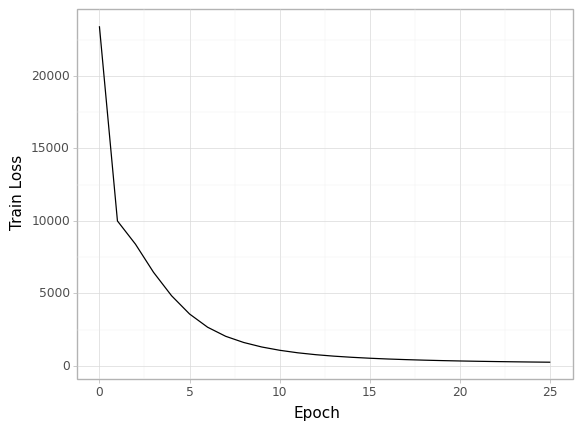

<ggplot: (8728495256182)>

In [29]:
(
    ggplot(train_scores, aes(x='Epoch', y='Train loss'))
        + geom_line(color='black') # line plot
        + labs(x='Epoch', y='Train Loss')
        + theme_light()
)

In [30]:
valid_scores = pd.DataFrame(np.hstack([(range(0, cfg.epochs+1, cfg.check_epoch), total_logs[score], [score for i in range(0, cfg.epochs+1, cfg.check_epoch)]) for score in ['Valid Recall@25', 'Valid NDCG@25', 'Valid Coverage', 'Valid Score']])).T
valid_scores.columns = ['Epoch', 'Score', 'Metric']
valid_scores['Epoch'] = valid_scores['Epoch'].astype(int)
valid_scores['Score'] = valid_scores['Score'].astype(float)

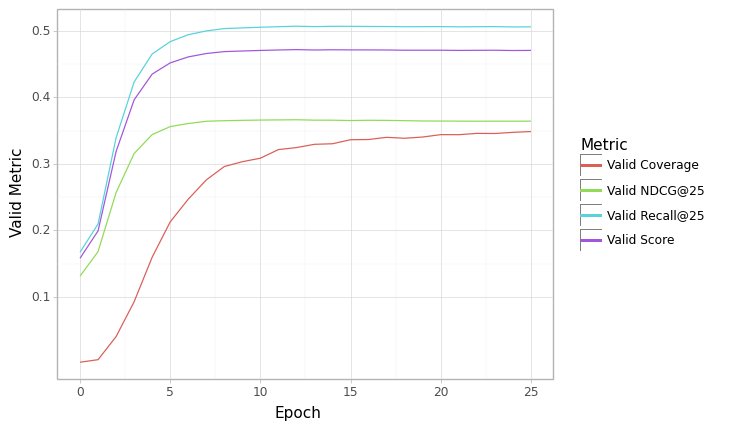

<ggplot: (8728495256173)>

In [31]:
(
ggplot(valid_scores)  # here
    + aes("Epoch", "Score", color='Metric', group='Metric')
    + geom_line()
    + scale_y_continuous(breaks=[0.1*c for c in range(1, 10, 1)])
    + theme_light()
    + labs(x='Epoch', y='Valid Metric')
)  

In [32]:
model.load_state_dict(torch.load(os.path.join(saved_path, 'model(best_scores).pth')))

<All keys matched successfully>

In [33]:
submission_path = os.path.join(data_path, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission = valid_epoch(cfg, model, submission, mode='test')

100%|██████████████████████████████████████| 8311/8311 [00:35<00:00, 233.57it/s]


In [34]:
submission.to_csv(os.path.join(output_path, 'submission_2.csv'), index = False)